In [3]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

### Introducción de Pytorch utilizando GPU

In [4]:
x = torch.randn(10000, 10000)
y = torch.randn(10000, 10000)

%time z = x*y  

CPU times: total: 203 ms
Wall time: 123 ms


In [5]:
x = torch.randn(10000, 10000).cuda()
y = torch.randn(10000, 10000).cuda()

%time z = x*y  

CPU times: total: 0 ns
Wall time: 29 ms


In [6]:
device = torch.device('cuda')

x = torch.randn((10000, 10000), device = device)
x = torch.randn((10000, 10000), device = device)

%time z = x*y

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
del x, y

### Implementación de Multi Layer Perceptron para la base de datos mnist

In [1]:
mnist = fetch_openml('mnist_784', version = 1)
X, Y = mnist['data'], mnist['target']

X.shape, Y.shape

((70000, 784), (70000,))

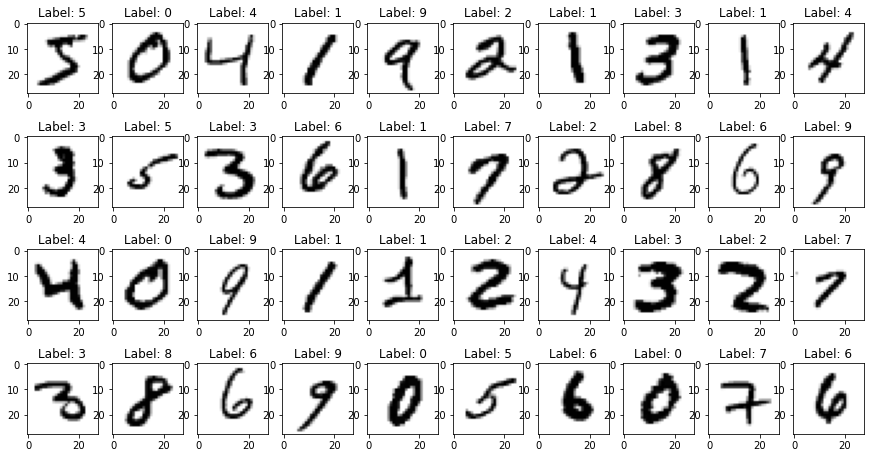

In [69]:
n_row = 4
n_col = 10

fig, axes = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))

for i in range(n_row * n_col):
    image = X.iloc[i].values

    ax = axes[i//n_col, i % n_col]
    ax.imshow(np.reshape(image, (28,28)), cmap='gray_r')
    ax.set_title('Label: {}'.format(Y.iloc[i]))
plt.show()

In [4]:
X_train, X_test, y_train, y_test = X[:60000]/255., X[60000:]/255. , Y[:60000].astype(np.int8), Y[60000:].astype(np.int8)
del X, Y

In [5]:
# función de pérdida y gradiente

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis = -1, keepdims = True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis = -1)) 
    loss = loss.mean()
    return loss

In [6]:
# Hiperparámetros de la red

d_in = 784          # dimensión de los datos de entrada
h = 100             # número de nodos en cada capa oculta
d_out = 10          # dimensión del espacio de predicción
epochs = 150        # épocas de entrenamiento
lr = 0.5            # learning rate
le = 10             # frecuencia de épocas para mostrar el progreso de entrenamiento

# Pesos y cesgo de la red neuronal

w1 = torch.tensor(np.random.normal(loc = 0.0, 
                                   scale = np.sqrt(2/(d_in + h)),
                                   size = (d_in, h)),
                  requires_grad = True,
                  device = 'cuda',
                  dtype = torch.double)

b1 = torch.zeros(h, requires_grad = True, device = 'cuda', dtype = torch.float)

w2 = torch.tensor(np.random.normal(loc = 0.0, 
                                   scale = np.sqrt(2/(d_out + h)),
                                   size = (h, d_out)),
                  requires_grad = True,
                  device = 'cuda',
                  dtype = torch.double)

b2 = torch.zeros(d_out, requires_grad = True, device = 'cuda', dtype = torch.float)

# Transformamos datos en tensores almacenados en gpu

X_t = torch.from_numpy(np.array(X_train)).cuda()
y_t = torch.from_numpy(np.array(y_train)).long().cuda()

In [7]:
# Entrenamos el modelo
l = []
for e in range(1, epochs+1):

    # paso hacia delante
    h = X_t.mm(w1) + b1
    h_relu = h.clamp(min = 0) # función de activación relu
    y_pred = h_relu.mm(w2) + b2

    # calulamos la pérdida
    loss = cross_entropy(y_pred, y_t)
    l.append(loss.item())

    # Se calculan los gradientes para realizar el Backpropagation
    loss.backward()

    # Actualizamos los pesos sin alterar el gradiente
    with torch.no_grad():
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad

        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # reiniciamos los gradientes para evitar la aculumación de los mismos
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()

        if not e % le :
            print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/150 Loss 1.46291
Epoch 20/150 Loss 1.11763
Epoch 30/150 Loss 0.93238
Epoch 40/150 Loss 0.80596
Epoch 50/150 Loss 0.73107
Epoch 60/150 Loss 0.66732
Epoch 70/150 Loss 0.61771
Epoch 80/150 Loss 0.57868
Epoch 90/150 Loss 0.54721
Epoch 100/150 Loss 0.52145
Epoch 110/150 Loss 0.49932
Epoch 120/150 Loss 0.47974
Epoch 130/150 Loss 0.46246
Epoch 140/150 Loss 0.44712
Epoch 150/150 Loss 0.43338


In [8]:
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu = h.clamp(min = 0)
    y_pred = h_relu.mm(w2) + b2
    y_prob = softmax(y_pred)
    return torch.argmax(y_prob, axis=1)

In [9]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(np.array(X_test)).cuda())
accuracy_score(y_test, y_pred.cpu().numpy())


0.9351

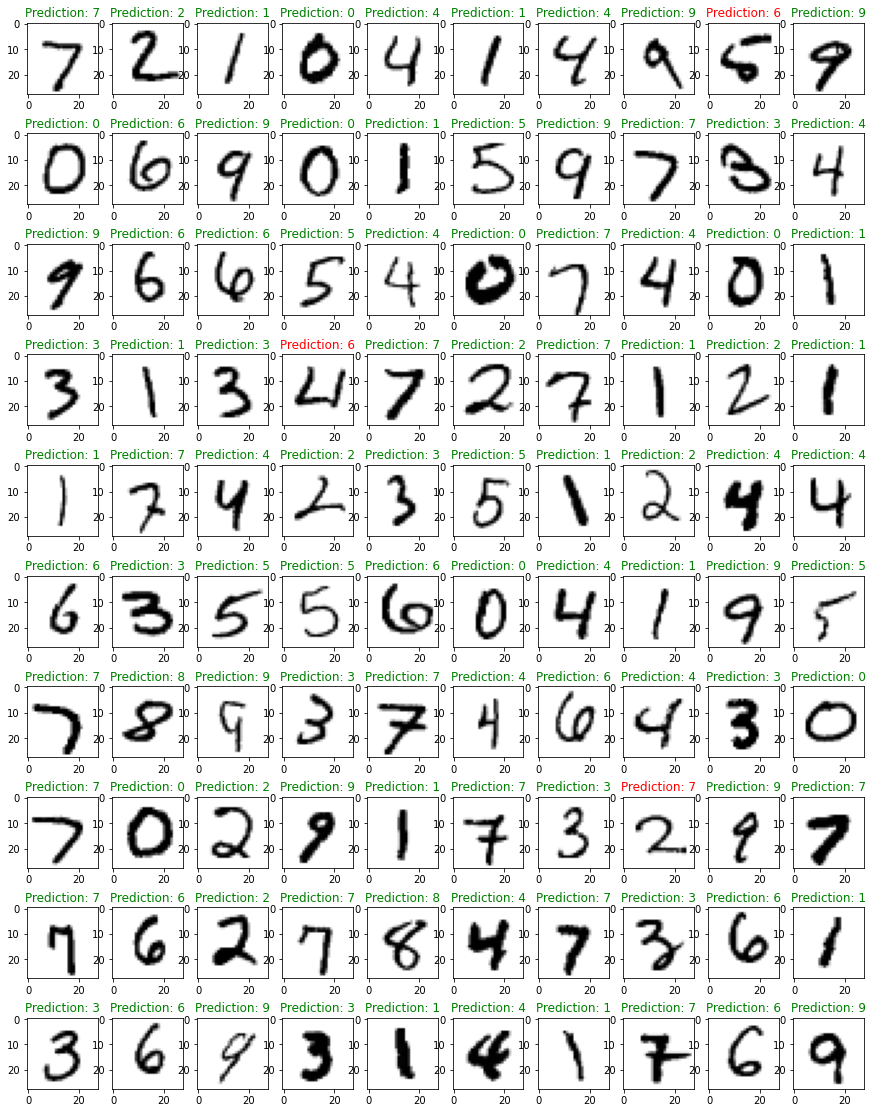

In [21]:
n_row = 10
n_col = 10

fig, axes = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))

for i in range(n_row * n_col):
    image = X_test.iloc[i].values

    ax = axes[i//n_col, i % n_col]
    ax.imshow(np.reshape(image, (28,28)), cmap='gray_r')
    if y_pred[i] != y_test.iloc[i]:
        color = 'red'
    else:
        color = 'green'
    ax.set_title('Prediction: {}'.format(y_pred[i]), color = color)
plt.show()